In [49]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from netCDF4 import Dataset
from shapely.geometry import mapping
from heatwaves.geographic import *
import zipfile
import os
import glob
from heatwaves.weather import *

# Calculating heat index using ERA5 data for the Philippines

Unzipping files

In [19]:
def unzip_files(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(zip_file_path))


In [32]:
files = glob.glob('../../data/remotesensing/era5/temperature/*.zip')
for file in files:
    #print(file)
    zip_file_path = file 
    unzip_files(zip_file_path)

Reading files, clipping geographical boundaries

In [4]:
PHILIPPINES  = geopandas.read_file('../../data/shapefiles/philippines/phl_adminboundaries_candidate_exclude_adm3/phl_admbnda_adm2_psa_namria_20200529.shp')
MANILA = PHILIPPINES[PHILIPPINES['ADM2_EN'].isin(['NCR, City of Manila, First District', 'NCR, Second District', 'NCR, Third District', 'NCR, Fourth District'])]

In [33]:
ds = xr.open_mfdataset('../../data/remotesensing/era5/temperature/*.nc', parallel=True)
df = clip_area(ds, MANILA).to_dataframe()

Converting Kelvin to Celcius

In [52]:
for column in ['Temperature_Air_2m_Max_Day_Time',
       'Temperature_Air_2m_Mean_Day_Time',
       'Temperature_Air_2m_Mean_Night_Time',
       'Temperature_Air_2m_Min_Night_Time']:
    df[column] = df[column].apply(lambda x: convert_kelvin_to_celcius(x))

### Definitions of each of the temperature variables

Daytime is considered to be 6AM to 6PM local time
Night time is considered to be 6PM to 6AM local time

Relative humidity values are collected 6AM, 9AM, 12PM, 3PM and 6PM resepctively. 

To calculate heat index separately for night time and day time, the 6AM relative humidity value is considered to be the night time value. This is owing to the fact that relative humidity is the highest when the temperature is at the lowest. 

To calculate heat index during the day, an average value of humidity is taken between the 9Am-6PM values

<Axes: xlabel='time'>

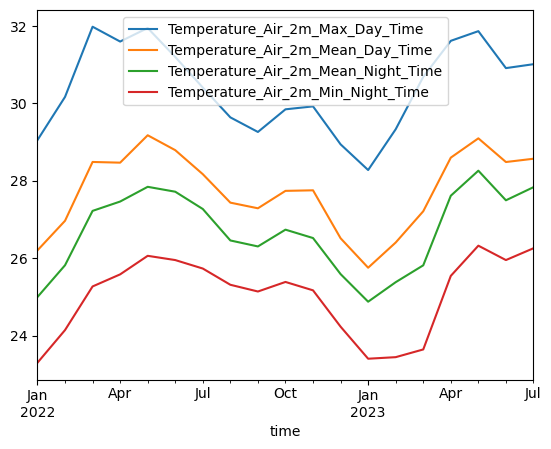

In [57]:
df.reset_index().groupby(pd.Grouper(key='time', freq='M')).mean()[['Temperature_Air_2m_Max_Day_Time',
       'Temperature_Air_2m_Mean_Day_Time',
       'Temperature_Air_2m_Mean_Night_Time',
       'Temperature_Air_2m_Min_Night_Time']].plot()

In [75]:
#ds_rh = xr.open_mfdataset('../../data/remotesensing/era5/relativehumidity/*.nc', parallel=True)
df_rh = clip_area(ds_rh, MANILA).to_dataframe()

In [65]:
df_rh.columns

Index(['spatial_ref', 'Relative_Humidity_2m_06h', 'Relative_Humidity_2m_09h',
       'Relative_Humidity_2m_12h', 'Relative_Humidity_2m_15h',
       'Relative_Humidity_2m_18h'],
      dtype='object')

<Axes: xlabel='time'>

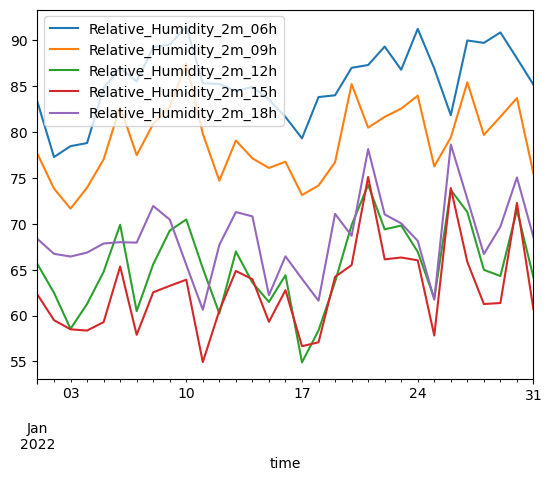

In [66]:
df_rh.reset_index().groupby('time').mean()[['Relative_Humidity_2m_06h', 'Relative_Humidity_2m_09h',
       'Relative_Humidity_2m_12h', 'Relative_Humidity_2m_15h',
       'Relative_Humidity_2m_18h']].plot()

In [76]:
df_rh['Relative_Humidity_Night'] = df_rh['Relative_Humidity_2m_06h']
df_rh['Relative_Humidity_Day_Mean'] = df_rh[[ 'Relative_Humidity_2m_09h',
       'Relative_Humidity_2m_12h', 'Relative_Humidity_2m_15h',
       'Relative_Humidity_2m_18h']].mean(axis=1)
df_rh['Relative_Humidity_Day_Min'] = df_rh[[ 'Relative_Humidity_2m_09h',
       'Relative_Humidity_2m_12h', 'Relative_Humidity_2m_15h',
       'Relative_Humidity_2m_18h']].min(axis=1)
df_rh['Relative_Humidity_Day_Max'] = df_rh[[ 'Relative_Humidity_2m_09h',
       'Relative_Humidity_2m_12h', 'Relative_Humidity_2m_15h',
       'Relative_Humidity_2m_18h']].max(axis=1)

In [77]:
heat_index = df.reset_index().merge(df_rh.reset_index())

### Calculating different aggregations for heat index

1. Heat Index Day Mean: Mean day time temperature, Mean day time relative humidity
2. Heat Index Night Min: Min night time temperature, min night time relative humidity
3. Heat Index Day Max: Max day time temperature, Max day time relative humidity

In [78]:
heat_index.columns

Index(['lat', 'lon', 'time', 'spatial_ref', 'Temperature_Air_2m_Max_Day_Time',
       'Temperature_Air_2m_Mean_Day_Time',
       'Temperature_Air_2m_Mean_Night_Time',
       'Temperature_Air_2m_Min_Night_Time', 'Relative_Humidity_2m_06h',
       'Relative_Humidity_2m_09h', 'Relative_Humidity_2m_12h',
       'Relative_Humidity_2m_15h', 'Relative_Humidity_2m_18h',
       'Relative_Humidity_Night', 'Relative_Humidity_Day_Mean',
       'Relative_Humidity_Day_Min', 'Relative_Humidity_Day_Max'],
      dtype='object')

In [80]:
heat_index['heat_index_day_mean'] = heat_index.apply(lambda x: convert_fahrenheit_to_celcius(calculate_heat_index(convert_celcius_to_fahrenheit(x['Temperature_Air_2m_Mean_Day_Time']), x['Relative_Humidity_Day_Mean'])), axis=1)

In [82]:
#heat_index['heat_index_day_min'] = heat_index.apply(lambda x: convert_fahrenheit_to_celcius(calculate_heat_index(convert_celcius_to_fahrenheit(x['Temperature_Air_2m_Min_Day_Time']), x['Relative_Humidity_Day_Min'])), axis=1)
heat_index['heat_index_day_max'] = heat_index.apply(lambda x: convert_fahrenheit_to_celcius(calculate_heat_index(convert_celcius_to_fahrenheit(x['Temperature_Air_2m_Max_Day_Time']), x['Relative_Humidity_Day_Max'])), axis=1)
heat_index['heat_index_night_min'] = heat_index.apply(lambda x: convert_fahrenheit_to_celcius(calculate_heat_index(convert_celcius_to_fahrenheit(x['Temperature_Air_2m_Min_Night_Time']), x['Relative_Humidity_Night'])), axis=1)

In [83]:
#heat_index.to_csv()

,lat,lon,time,spatial_ref,Temperature_Air_2m_Max_Day_Time,Temperature_Air_2m_Mean_Day_Time,Temperature_Air_2m_Mean_Night_Time,Temperature_Air_2m_Min_Night_Time,Relative_Humidity_2m_06h,Relative_Humidity_2m_09h,Relative_Humidity_2m_12h,Relative_Humidity_2m_15h,Relative_Humidity_2m_18h,Relative_Humidity_Night,Relative_Humidity_Day_Mean,Relative_Humidity_Day_Min,Relative_Humidity_Day_Max,heat_index_day_mean,heat_index_day_max,heat_index_night_min
0,14.8,120.9,2022-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14.8,120.9,2022-01-02,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14.8,120.9,2022-01-03,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14.8,120.9,2022-01-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14.8,120.9,2022-01-05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,14.4,121.1,2022-01-27,0,29.040704,27.086938,26.097437,25.829065,84.172058,83.863770,76.672661,74.227982,78.401482,84.172058,78.291473,74.227982,83.863770,29.766511,35.729406,27.452966
461,14.4,121.1,2022-01-28,0,29.006708,27.242120,26.558008,25.682214,86.214989,83.234474,73.266808,67.877190,70.891174,86.214989,73.817413,67.877190,83.234474,29.642214,35.481459,27.181632
462,14.4,121.1,2022-01-29,0,29.604852,27.358240,26.961359,25.673059,87.853409,86.204170,71.261810,67.687500,72.966698,87.853409,74.530045,67.687500,86.204170,29.945122,38.170142,27.189428
463,14.4,121.1,2022-01-30,0,28.433496,26.890894,27.363184,25.977441,85.591583,85.029503,77.432755,75.151939,76.219368,85.591583,78.458389,75.151939,85.029503,29.366081,34.154951,27.822222
